# Task 1 - Fashion MNIST
Define, train, and test a simple CNN that classifies images in the Fashion-MNIST dataset, introduced in the paper "Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms" 

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [42]:
import torch.nn as nn
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display


In [ ]:
def get_path(task_number, *args):
    notebook_path = os.path.abspath(f"Task {task_number}.ipynb")
    return os.path.join(os.path.dirname(notebook_path), *args)

In [45]:
train_data_path = get_path(1, "data", "train", "train-images-idx3-ubyte")
train_labels_path = get_path(1, "data", "train", "train-labels-idx1-ubyte")

test_data_path = get_path(1, "data", "test", "t10k-images-idx3-ubyte")
test_labels_path = get_path(1, "data", "test", "t10k-labels-idx1-ubyte")

model_path = get_path(1, "model", "fashion_mnist_cnn.pt")

# Load function for the data
def load_data(data_path, labels_path):
    with open(data_path, "rb") as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)
    with open(labels_path, "rb") as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return data, labels


In [ ]:
# Load the training data
train_data, train_labels = load_data(train_data_path, train_labels_path)

# Load the test data
test_data, test_labels = load_data(test_data_path, test_labels_path)

In [3]:
# Define the CNN
# Network Architecture is inspired by CV1 Assignment No. 5
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*256, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        out = self.conv(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [76]:
# set network and training parameters
lr = 1e-2
batch_size = 5
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.train()

# setup loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)

In [ ]:
losses = []

# Iterate through number of epochs and determine next step
for epoch in range(num_epochs):
    for i in range(0, train_data.shape[0], batch_size):
        # get batch of data
        inputs = torch.tensor(train_data[i:i+batch_size].reshape(-1, 1, 28, 28)/255, dtype=torch.float32).to(device)
        labels = torch.tensor(train_labels[i:i+batch_size], dtype=torch.long).to(device)
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print loss
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, (i+1)//batch_size, train_data.shape[0]//batch_size, loss.item()))
        
        # Draw plot of loss
        # losses.append(loss.item())
        # pl.plot(losses, 'b')
        # display.clear_output(wait=True)
        # display.display(pl.gcf())
      
    # Save the model here, in case of interruption or if I'm bored cause my cpu too slow  
    torch.save(model.state_dict(), model_path)


print("Training finished")

In [47]:
# Save the Model
torch.save(model.state_dict(), model_path)

In [79]:
# Load the Model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

Accuracy of the network on test images 1-5: 100.0 %


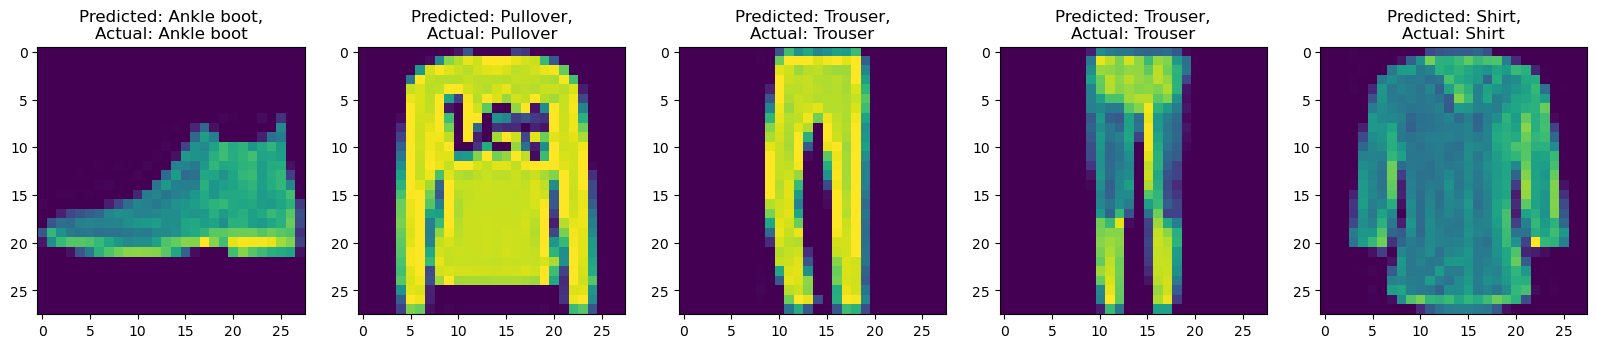

Accuracy of the network on test images 6-10: 100.0 %


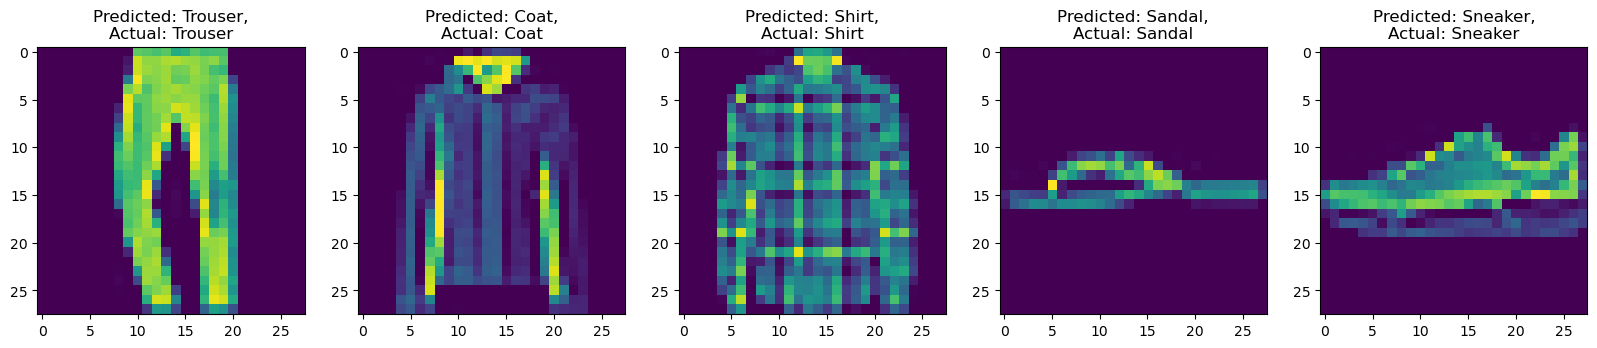

Accuracy of the network on test images 11-15: 93.3333 %


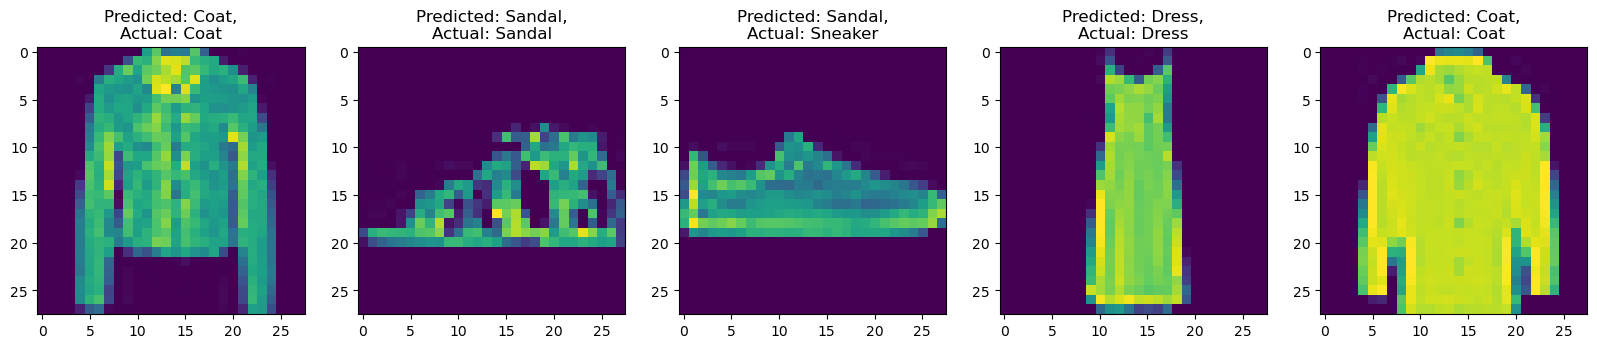

Accuracy of the network on test images 16-20: 90.0 %


KeyboardInterrupt: 

In [82]:
# Test the saved model on the MNIST Test-Data

# Only relevant for the plot
size_constraint = 100
figsize = (size_constraint//batch_size, size_constraint//batch_size)

correct = 0
total = 0

with torch.no_grad():
    for i in range(0, test_data.shape[0], batch_size):
                
        inputs = torch.tensor(test_data[i:i+batch_size].reshape(-1, 1, 28, 28)/255, dtype=torch.float32).to(device)
        true_labels = torch.tensor(test_labels[i:i+batch_size], dtype=torch.long).to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += true_labels.size(0)
        correct += (predicted == true_labels).sum().item()
        
        # Print the accuracy
        print(f"Accuracy of the network on test images {i+1}-{i+batch_size}: {round(100 * correct / total, 4)} %")
        
        # Plot the images
        f, axarr = plt.subplots(1, batch_size, figsize=figsize)
        for k in range(batch_size):   
            axarr[k].imshow(test_data[i:i+batch_size][k], interpolation='nearest')
            axarr[k].set_title(f"Predicted: {labels[predicted[k]]},\nActual: {labels[true_labels[k]]}")
        plt.show()
        
